# CIFAR 10 Dataset Analysis
A simple Convolutional Neural Netowrk (CNN) that classifies various 32 x 32 images from the CIFAR 10 Dataset. 
You can find more info about the dataset here: https://www.cs.toronto.edu/~kriz/cifar.html 

## Module Imports ##

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pandas as pd
from random import shuffle, randint
from tqdm import tqdm
from math import ceil

## Load Data ##

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

augment = transforms.Compose([
    # transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

std_data = datasets.CIFAR10(
    root='./data',
    download=True,
    transform=augment
)

aug_data = datasets.CIFAR10(
    root='./data',
    download=True,
    transform=transform
)

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(f"Training using {torch.cuda.get_device_name(0)}")
objects = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
batch_size = 64

train_data = torch.utils.data.ConcatDataset([std_data, aug_data])
test_data = datasets.CIFAR10(root='./data',download=True,train=False,transform=transform)

train_data = DataLoader(train_data, batch_size=batch_size)
test_data = DataLoader(test_data, batch_size=batch_size)

Training using NVIDIA GeForce RTX 3070


## Image display ##
Let's look at an image to see what the model will be tested on

torch.Size([64, 3, 32, 32])


C:\Users\Lucas Jiao\AppData\Local\Temp\ipykernel_6404\4274216291.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  plt.imshow(torch.rot90((image.T * 0.5 + 0.5), k=3))


Text(0.5, 1.0, 'Sample Image')

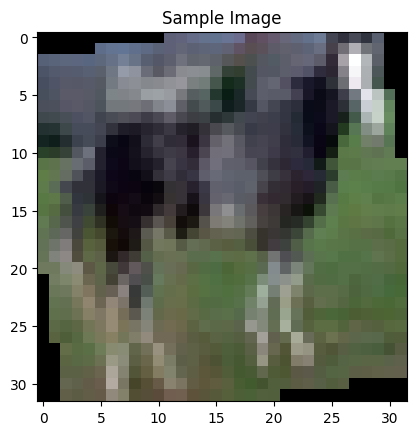

In [3]:
images, label = next(iter(train_data))
idx = randint(0, batch_size-1)
image = images[idx]
print(images.shape)
plt.imshow(torch.rot90((image.T * 0.5 + 0.5), k=3))
plt.title("Sample Image")

## CNN Structure ##

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(2048, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x

In [5]:
model = CNN().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
crit = nn.CrossEntropyLoss()

## Training Procedure ##

In [6]:
epoch_data = pd.DataFrame({
    "Training Loss" : [],
    "Validation Loss" : [],
    "Training Accuracy" : [],
    "Validation Accuracy" : []
})
epoch_num = 15

def test_accuracy(data):
    model.eval()
    correct = 0
    size = len(data.dataset)
    with tqdm(desc="Validation in progress...", total=ceil(size / batch_size)) as pbar:
        with torch.no_grad():
            for x, y in data:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                correct += (pred.argmax(1) == y).sum().item()
                loss = crit(pred, y)
                pbar.update(1)

    return loss.item(), correct / size * 100

def train_epoch(epoch):
    model.train()
    with tqdm(desc="Training in progress...", total=ceil(len(train_data.dataset) / batch_size)) as pbar:
        for x, y in train_data:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            pred = model(x)
            loss = crit(pred, y)
            loss.backward()
            opt.step()
            pbar.update(1)

    epoch_data.loc[epoch, 'Training Loss'], epoch_data.loc[epoch, 'Training Accuracy'] = test_accuracy(train_data)
    epoch_data.loc[epoch, 'Validation Loss'] , epoch_data.loc[epoch, 'Validation Accuracy'] = test_accuracy(test_data)

for epoch in range(epoch_num):
    print(f"Epoch #{epoch+1}: ")
    train_epoch(epoch)

Epoch #1: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 129.51it/s]


Epoch #2: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 142.39it/s]


Epoch #3: 


Validation in progress...: 100%|██████████| 157/157 [00:02<00:00, 55.76it/s]


Epoch #4: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 109.07it/s]


Epoch #5: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 126.57it/s]


Epoch #6: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 109.40it/s]


Epoch #7: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 127.92it/s]


Epoch #8: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 125.26it/s]


Epoch #9: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 122.67it/s]


Epoch #10: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 141.51it/s]


Epoch #11: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 111.11it/s]


Epoch #12: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 109.94it/s]


Epoch #13: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 109.47it/s]


Epoch #14: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 108.76it/s]


Epoch #15: 


Validation in progress...: 100%|██████████| 157/157 [00:01<00:00, 140.85it/s]


## Results ## 

In [7]:
epoch_data

,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy
0,0.688034,0.750036,78.959,77.96
1,0.294964,0.745334,86.239,82.93
2,0.166341,0.444487,88.769,83.58
3,0.102769,0.301713,90.705,84.26
4,0.064024,0.537637,92.761,84.44
5,0.025843,0.483966,93.617,85.30
6,0.029510,0.439821,94.198,85.49
7,0.051900,0.384072,94.831,85.81
8,0.023328,0.406781,95.819,86.37
9,0.018864,0.320389,95.876,86.30


Text(0, 0.5, 'Accuracy (%)')

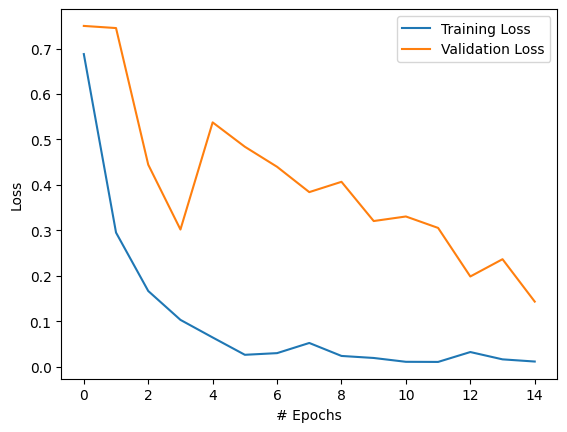

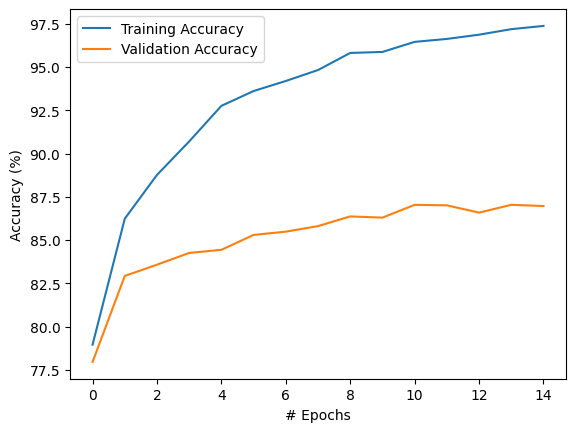

In [8]:
g1 = epoch_data[['Training Loss', 'Validation Loss']].plot()
g2 = epoch_data[['Training Accuracy', 'Validation Accuracy']].plot()
g1.set_xlabel("# Epochs")
g1.set_ylabel("Loss")
g2.set_xlabel("# Epochs")
g2.set_ylabel("Accuracy (%)")

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1000
           1       0.94      0.93      0.94      1000
           2       0.81      0.83      0.82      1000
           3       0.78      0.71      0.74      1000
           4       0.84      0.86      0.85      1000
           5       0.79      0.83      0.81      1000
           6       0.89      0.90      0.90      1000
           7       0.90      0.89      0.89      1000
           8       0.94      0.93      0.93      1000
           9       0.92      0.91      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



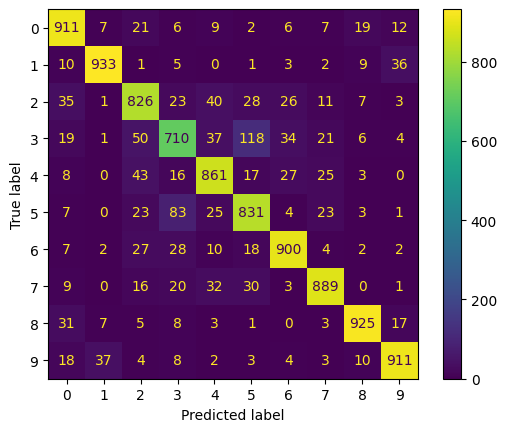

In [9]:
y_pred, y_test = [] , []
for data, label in test_data:
    pred = model(data.to(device)).argmax(1)
    y_pred.extend(pred.cpu().numpy())
    y_test.extend(label.cpu().numpy())

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm).plot()

Now, let's see how the model responds to pictures from the validation set

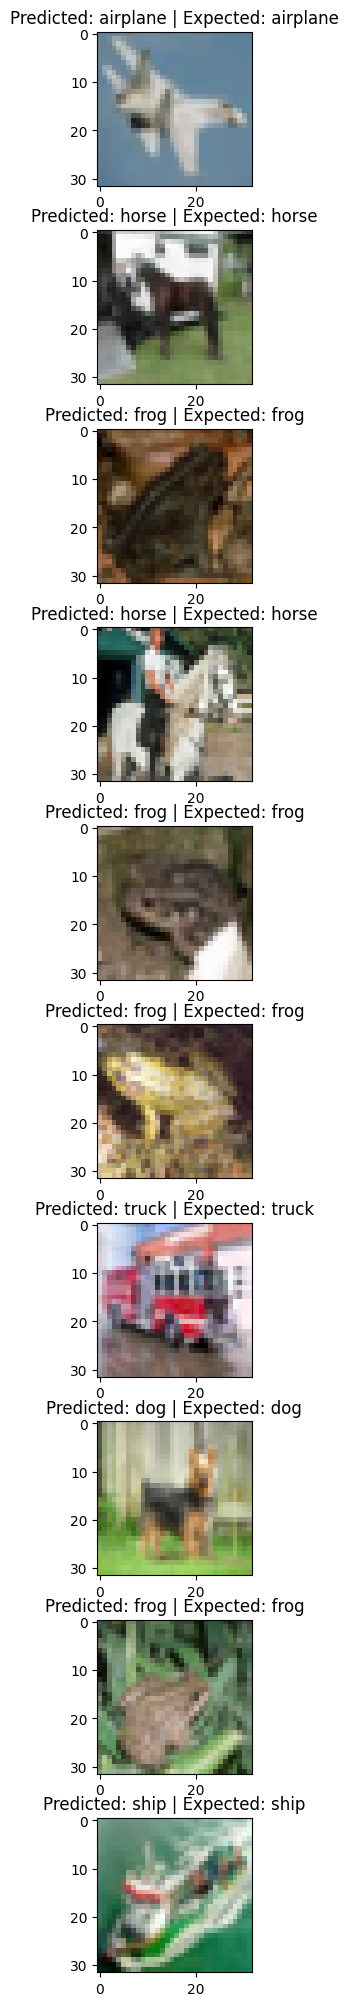

In [14]:
def display_img(dataset):
    images, label = next(iter(dataset))
    preds = model(images.to(device)).argmax(1)
    fig, axes = plt.subplots(10, 1, figsize=(20,20))
    fig.tight_layout()
    pictures = list(range(0, 63))
    shuffle(pictures)
    for i in range(10):
        idx = pictures[i]
        image = images[idx]
        axes[i].imshow(torch.rot90((image.T * 0.5 + 0.5), k=3))
        axes[i].set_title(f"Predicted: {objects[preds[idx]]} | Expected: {objects[label[idx]]}")

display_img(test_data)

Let's try this on some custom images!

Text(0.5, 1.0, 'Hmm, I think this is a ship')

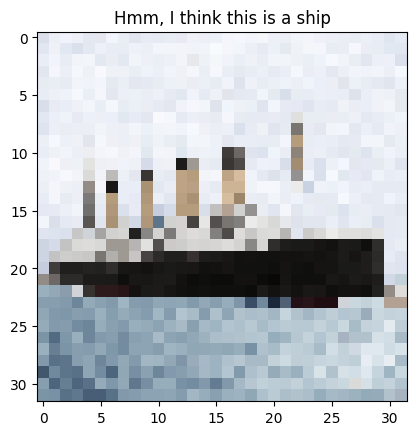

In [19]:
from PIL import Image
path = "pictures\\14047.webp"
image = Image.open(path).resize((32,32))
image = image.convert('RGB')
data = transform(image).reshape(1,3,32,32)
model.eval()
pred = model(data.to(device))
plt.imshow(image)
plt.title(f"Hmm, I think this is a {objects[pred.argmax(1)]}")

## Thanks for reading!! ##
Pls support an aspiring cs student so his future career does not get cooked by AI